In [136]:
#IMPORTS

import pandas as pd # to read sql data into a pandas dataframe
import psycopg2 # to connect to SQL database
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import missingno as msno
import haversine as hs
from haversine import haversine, Unit
import warnings

warnings.filterwarnings("ignore")

# <span style="color:green"> __Preliminary Data Cleaning__ </span>

The first thing to do is make a data frame from the CSV file generated from DBeaver. This is contained within the "data" folder so this must be included in the file path in order for it to be fetched

In [137]:
df_king_county = pd.read_csv('./data/king_county_data_joined.csv')
df_king_county.head() #I check the first 5 rows of this to make sure that it imported correctly

#now I want to clean the data frame a bit
#I remove the id.1 column which is a repeat of the house_id
#and delete the id column which seems irrelevant... (some sort of sales id)

df_king_county = df_king_county.drop(columns=['id.1', 'id'])

df_king_county.columns #this verifies that it was done correctly

Index(['date', 'price', 'house_id', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

## <span style="color:lightgreen"> __Variable Types__ </span>


Now that I know the column heads, I should write a little description of each, mentioning also if they are continuous or categorical

* date: qualitative ordinal

* price: quantitative continuous

* house_id: qualitiative nominal

* bedrooms: quantitative discrete
* bathrooms: quantitative discrete
* sqft_living: quantitative continuous
* sqft_lot: quantitative continuous
* floors: quantitative discrete
* waterfront: qualitative ordinal (0 or 1)
* view: qualitative ordinal
* condition: qualitative ordinal
* grade: qualitative ordinal
* sqft_above: quantitative continuous
* sqft_basement: quantitative continuous
* yr_built: qualitative ordinal
* yr_rennovated: qualitative ordinal
* zipcode: qualitative nominal
* lat: qualitative nominal
* long: qualitative nominal
* sqft_living15: quantitative continuous
* sqft_lot15: quantitative continuous


## <span style="color:lightgreen"> __Exploring the Data__ </span>


In [138]:
#check data types
df_king_county.info()


#check the shape of the data
df_king_county.shape

#check for duplicates
df_king_county.duplicated().value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   house_id       21597 non-null  int64  
 3   bedrooms       21597 non-null  float64
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  float64
 6   sqft_lot       21597 non-null  float64
 7   floors         21597 non-null  float64
 8   waterfront     19206 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  float64
 13  sqft_basement  21145 non-null  float64
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17749 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

False    21597
Name: count, dtype: int64

* When I run the cell above, I see off the bat something that I need to change. The 'date' column should be datetime format, but right now it is 'object.' Fortunately, all of the column names are already in snake case so that doesn't need to be adjusted. 

* When I check the shape of the data, I see that there are 21597 rows and 21 columns

* When I check for duplicates, I see that there are none, since the output is 'false' for 21597 rows

### <span style="color:lightgreen"> __Updating the Dates__ </span>


In [139]:
#As seen before, we need to change the dates to datetime format

# type(df_king_county['date'][0]) (tells me it is a string)

df_king_county['date'] = pd.to_datetime(df_king_county['date'], format='%Y-%m-%d')

type(df_king_county['date'][0]) #now verifies it's the correct type

pandas._libs.tslibs.timestamps.Timestamp

### <span style="color:lightgreen"> __Checking for Unique ELements__ </span>


In [140]:
df_king_county.nunique()

date               372
price             3622
house_id         21420
bedrooms            12
bathrooms           29
sqft_living       1034
sqft_lot          9776
floors               6
waterfront           2
view                 5
condition            5
grade               11
sqft_above         942
sqft_basement      303
yr_built           116
yr_renovated        70
zipcode             70
lat               5033
long               752
sqft_living15      777
sqft_lot15        8682
dtype: int64

### <span style="color:lightgreen"> __Checking for Missing Values__ </span>


In [141]:
# display number of missing values per column
df_king_county.isna().sum()

date                0
price               0
house_id            0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2391
view               63
condition           0
grade               0
sqft_above          0
sqft_basement     452
yr_built            0
yr_renovated     3848
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Running the cell above reveals that there are four "problem columns" which are "view," "waterfront," "sqft_basement," and "yr_rennovated". It is important to see if these missing values are grouped in any way. To do this, we can use an msno matrix. By running the cell below, I see that the missing values for "view" are all consecutive, and that the missing values for the other columns are somewhat random. For now, I will not adjust my data based on the missing values, because I am not sure yet how or what I want to explore.

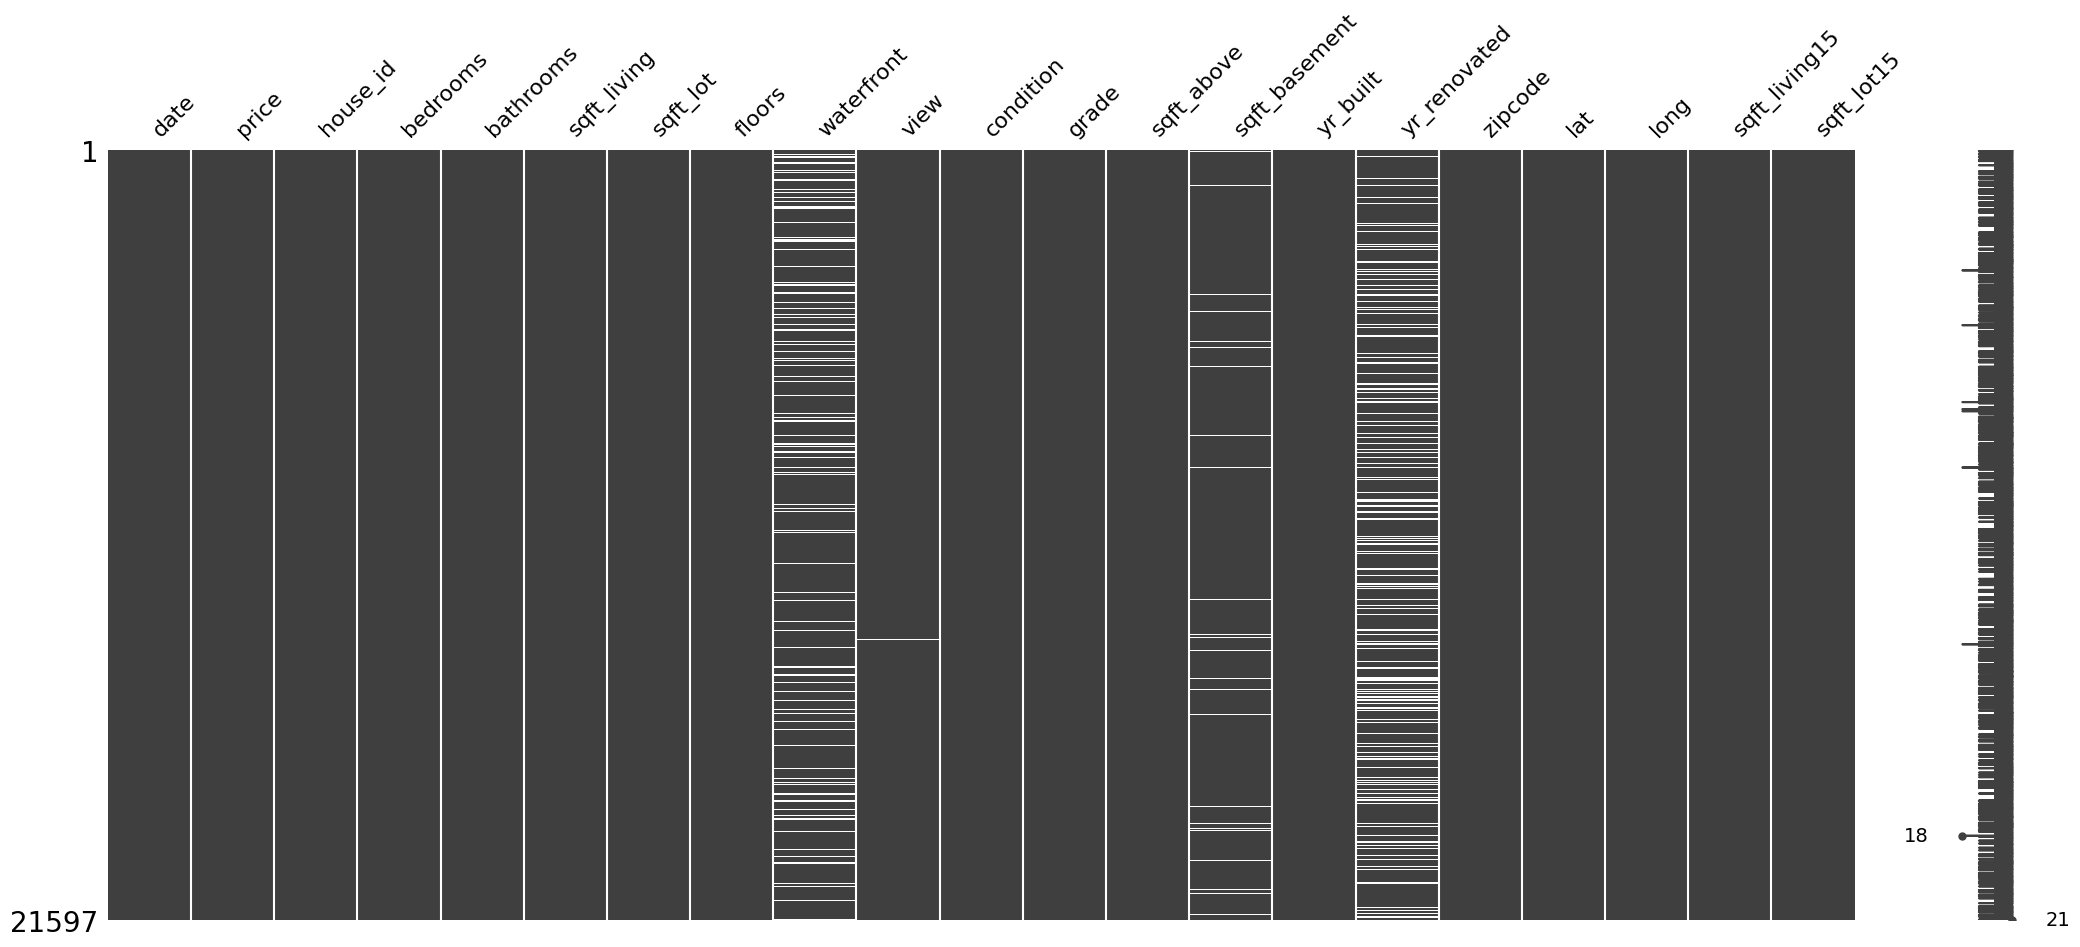

In [142]:
msno.matrix(df_king_county);

Before continuing, I think it's important to do two things - make a price per square foot column and make a column to determine if a house is or isn't in Seattle based on a search for Seattle ZIP codes.

In [143]:
#first I create the price per square foot column based on the sqft_living column:

df_king_county['price_per_sqft'] = df_king_county['price'] / df_king_county['sqft_living']

#Then I create a list of the ZIP codes which are actually in the city of Seattle

seattle_zip_codes = [98102, 98103, 98107, 98109, 98112, 98115, 98117, 98119, 98125, 98133, 
                     98177, 98105, 98106, 98108, 98112, 98116, 98118, 98122, 98126, 98134, 
                     98136, 98144, 98146, 98178, 98199, 98101, 98104, 98113, 98121, 98141, 
                     98154, 98161, 98165, 98170, 98174, 98175, 98181, 98185, 98190, 98191, 98194]


#now I add a column called "is_in_seattle" to the table which I want to have a True/False value 
#based on the zip codes in this list

df_king_county['is_in_seattle'] = df_king_county['zipcode'].isin(seattle_zip_codes)
df_king_county

#I want to see how much data we have for the city of Seattle to see if it's viable to make use of just that 

df_king_county.value_counts('is_in_seattle')

#this tells me that there are 7531 just in Seattle, which I think is sufficient as a "sub-dataframe" 
# to use later on


is_in_seattle
False    14066
True      7531
Name: count, dtype: int64

## <span style="color:lightgreen"> __Exploring the Data__ </span>

Let's start with the CONTINUOUS variables. These include:

* price: quantitative continuous

* sqft_living: quantitative continuous

* sqft_lot: quantitative continuous

* sqft_above: quantitative continuous

* sqft_basement: quantitative continuous

* sqft_living15: quantitative continuous

* sqft_lot15: quantitative continuous

In [144]:
df_king_county['price'].describe()

df_king_county.sort_values(by='price', ascending=False).head(10)

,date,price,house_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft,is_in_seattle
7245,2014-10-13,7700000.0,6762700020,6.0,8.00,12050.0,27600.0,2.5,0.0,3.0,...,3480.0,1910,19870.0,98102,47.6298,-122.323,3940.0,8800.0,639.004149,True
3910,2014-06-11,7060000.0,9808700762,5.0,4.50,10040.0,37325.0,2.0,1.0,2.0,...,2360.0,1940,20010.0,98004,47.6500,-122.214,3930.0,25449.0,703.187251,False
9245,2014-09-19,6890000.0,9208900037,6.0,7.75,9890.0,31374.0,2.0,0.0,4.0,...,1030.0,2001,0.0,98039,47.6305,-122.240,4540.0,42730.0,696.663296,False
4407,2014-08-04,5570000.0,2470100110,5.0,5.75,9200.0,35069.0,2.0,0.0,0.0,...,3000.0,2001,NaN,98039,47.6289,-122.233,3560.0,24345.0,605.434783,False
1446,2015-04-13,5350000.0,8907500070,5.0,5.00,8000.0,23985.0,2.0,0.0,4.0,...,1280.0,2009,0.0,98004,47.6232,-122.220,4600.0,21750.0,668.750000,False
1313,2015-04-13,5300000.0,7558700030,6.0,6.00,7390.0,24829.0,2.0,1.0,NaN,...,2390.0,1991,0.0,98040,47.5631,-122.210,4320.0,24619.0,717.185386,False
1162,2014-10-20,5110000.0,1247600105,5.0,5.25,8010.0,45517.0,2.0,1.0,4.0,...,2020.0,1999,0.0,98033,47.6767,-122.211,3430.0,26788.0,637.952559,False
8085,2014-06-17,4670000.0,1924059029,5.0,6.75,9640.0,13068.0,1.0,1.0,4.0,...,4820.0,1983,20090.0,98040,47.5570,-122.210,3270.0,10454.0,484.439834,False
2624,2014-08-15,4500000.0,7738500731,5.0,5.50,6640.0,40014.0,2.0,1.0,4.0,...,290.0,2004,0.0,98155,47.7493,-122.280,3030.0,23408.0,677.710843,False
8629,2014-06-18,4490000.0,3835500195,4.0,3.00,6430.0,27517.0,2.0,0.0,0.0,...,0.0,2001,0.0,98004,47.6208,-122.219,3720.0,14592.0,698.289269,False


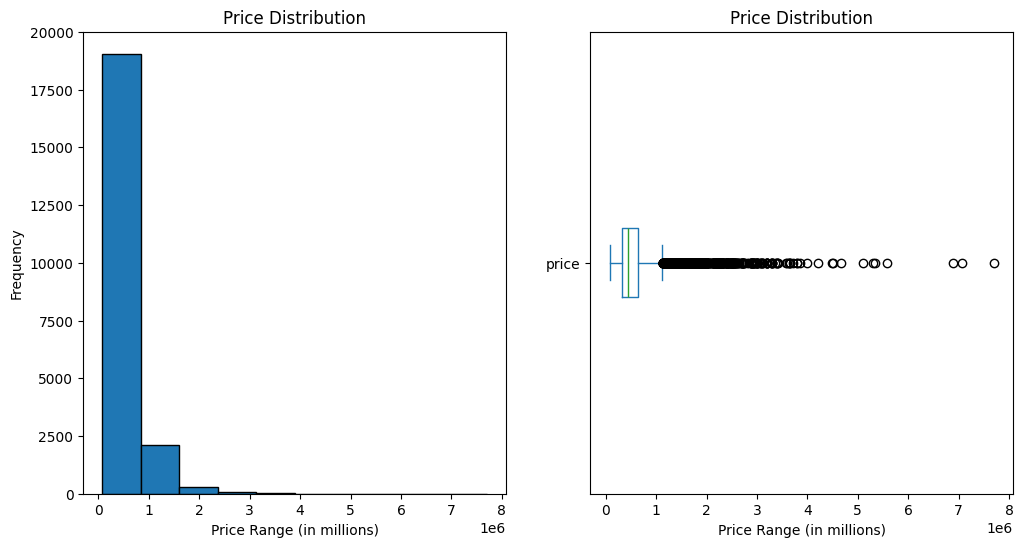

In [145]:
#STARTING WITH PRICE (I will make a histogram and a box plot to look at the data and display side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))     #this means that I will have 1 row with 2 columns (to display
                                                    # side by side)


#make the histogram which will show on the left (i.e. axis 0)
ax = df_king_county['price'].plot(kind='hist', edgecolor='black', ax=axes[0])
axes[0].set_xlabel('Price Range (in millions)')
axes[0].set_title('Price Distribution')
axes[0].set_ylabel('Frequency')


#make the box plot which will show on the right (i.e. axis 1)
df_king_county['price'].plot(kind='box', vert = False, ax=axes[1]) #I make this one horizontal so that the
                                                                   #price spread is comparable
axes[1].set_title('Price Distribution')
axes[1].set_xlabel('Price Range (in millions)')
axes[1].set_ylabel(' ')

# Show the plot
plt.show()

#These histogram is not so insightful since there are so many trailing values at the end (outliers)

We can take away that the distribution of prices is heavily skewed to the right due to a prevelance of outliers in a high price range. This is not very helpful to view because there are some houses above 1 million which means that the whole x-axis is in millions and therefore not so insightful. It is more helpful to use the .describe() function on the "price" column.

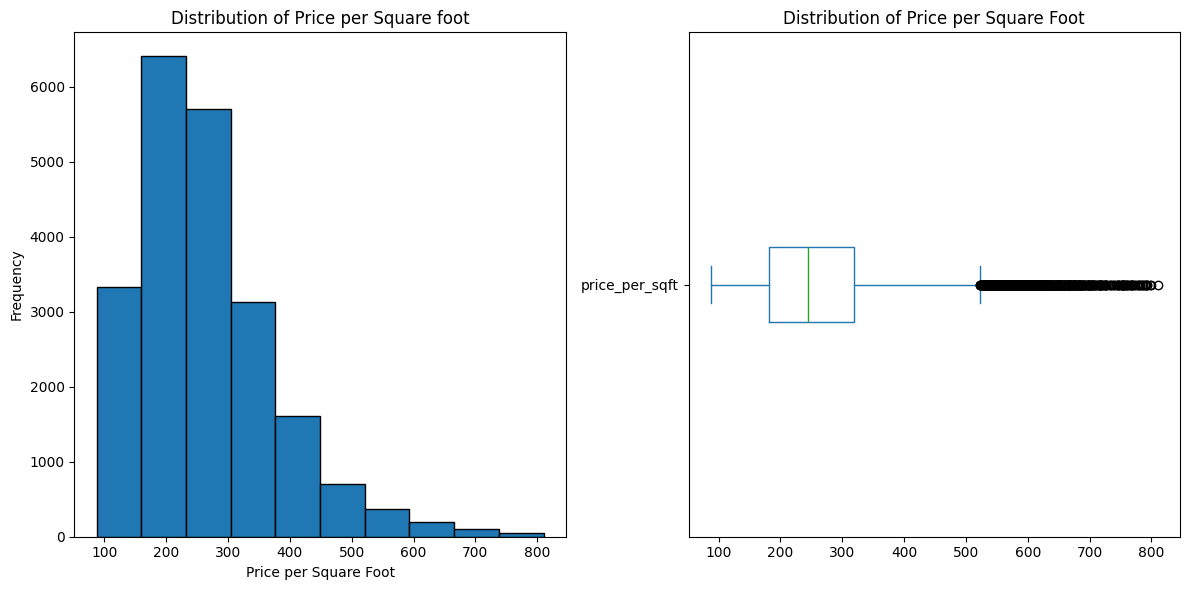

count    21597.000000
mean       264.143368
std        110.000061
min         87.588235
25%        182.291667
50%        244.644550
75%        318.333333
max        810.138889
Name: price_per_sqft, dtype: float64

In [146]:
#now I want to do the same thing except with the price per square foot column

fig, axes = plt.subplots(1, 2, figsize=(12, 6))


#make the histogram which will show on the left (i.e. axis 0)
ax = df_king_county['price_per_sqft'].plot(kind='hist', edgecolor='black', ax=axes[0])
axes[0].set_xlabel('Price per Square Foot')
axes[0].set_title('Distribution of Price per Square foot')
axes[0].set_ylabel('Frequency')


#make the box plot which will show on the right (i.e. axis 1)
df_king_county['price_per_sqft'].plot(kind='box', vert=False, ax=axes[1]) #I make the vertical "false" so that the axes correspond
axes[1].set_title('Distribution of Price per Square Foot')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

df_king_county['price_per_sqft'].describe()

Here we can clearly see the skew to the right and we can see the median represented (which is 244.64). We see from the box plot that there are tons of outliers in this column. When assessing the overall data this might come into play, but when considering the needs of my client it might not be so important.

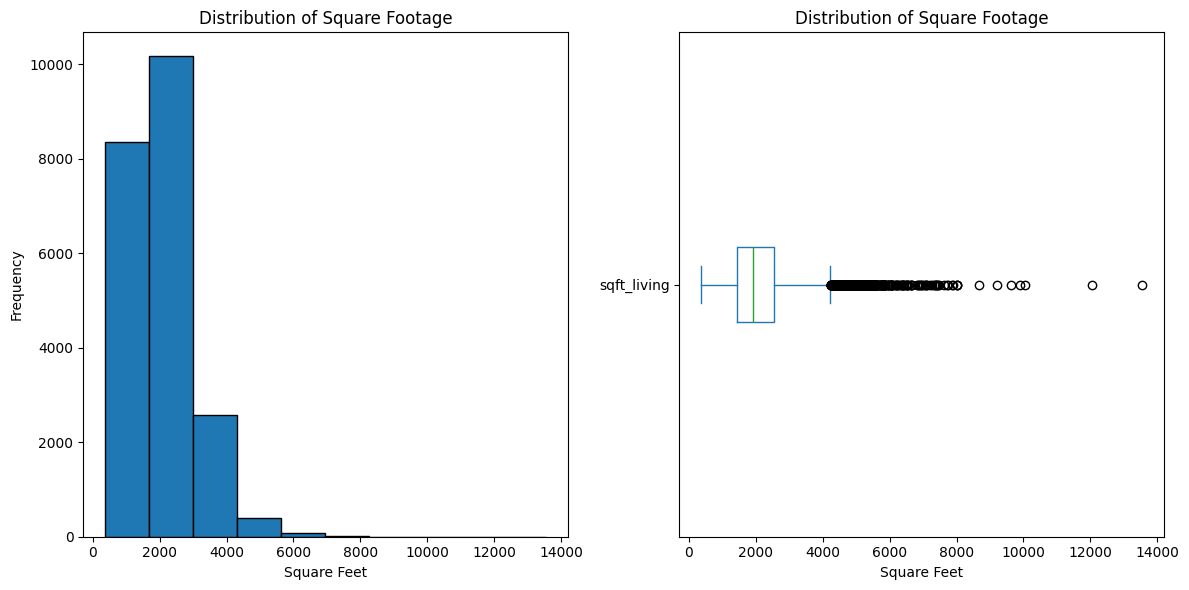

count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

In [147]:
#Now with sqft_living

fig, axes = plt.subplots(1, 2, figsize=(12, 6))


#make the histogram which will show on the left (i.e. axis 0)
ax = df_king_county['sqft_living'].plot(kind='hist', edgecolor='black', ax=axes[0])
axes[0].set_xlabel('Square Feet')
axes[0].set_title('Distribution of Square Footage')
axes[0].set_ylabel('Frequency')


#make the box plot which will show on the right (i.e. axis 1)
df_king_county['sqft_living'].plot(kind='box', vert=False, ax=axes[1]) #I make the vertical "false" so that the axes correspond
axes[1].set_title('Distribution of Square Footage')
axes[1].set_xlabel('Square Feet')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

df_king_county['sqft_living'].describe()

There are also many outliers skewing this distribution, but we can see where the values are mostly concentrated based on the histogram. This is helpful to know despite the skew. 

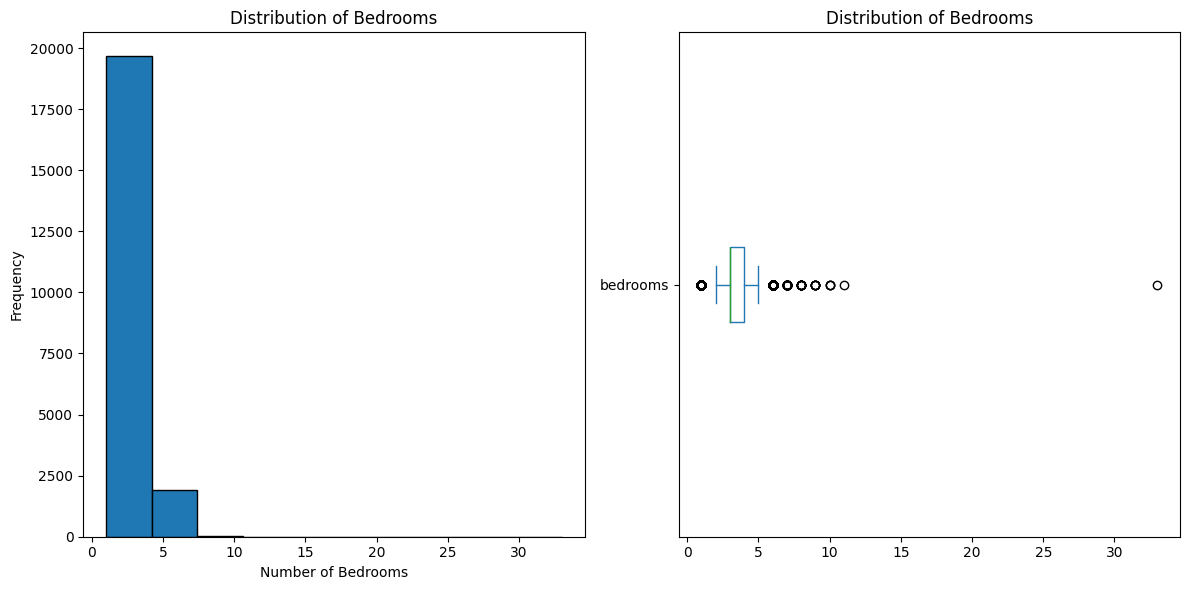

In [148]:
#now for bedrooms since this seems like the other one which is most relevant

fig, axes = plt.subplots(1, 2, figsize=(12, 6))


#make the histogram which will show on the left (i.e. axis 0)
ax = df_king_county['bedrooms'].plot(kind='hist', edgecolor='black', ax=axes[0])
axes[0].set_xlabel('Number of Bedrooms')
axes[0].set_title('Distribution of Bedrooms')
axes[0].set_ylabel('Frequency')


#make the box plot which will show on the right (i.e. axis 1)
df_king_county['bedrooms'].plot(kind='box', vert=False, ax=axes[1]) #I make the vertical "false" so that the axes correspond
axes[1].set_title('Distribution of Bedrooms')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

Again there is a major outlier when it comes to the number of bedrooms (33). For housekeeping since this one is so much farther than the other outliers, it may be a good idea to remove that row when I am actually working with the data for my hypotheses.

### <span style="color:lightgreen"> __Taking Care of Outliers__ </span>

In [149]:
outlier_counts = {}

for column in df_king_county.select_dtypes(include='number'):  # Select only numeric columns
    Q1 = df_king_county[column].quantile(0.25)  # 25th percentile
    Q3 = df_king_county[column].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile Range

    # Calculate outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_king_county[(df_king_county[column] < lower_bound) | (df_king_county[column] > upper_bound)]

    # Count outliers
    outlier_counts[column] = outliers.shape[0]

# Display the result
print("Number of outliers in each column:")
for column, count in outlier_counts.items():
    print(f"{column}: {count}") #I want it to print vertically for readability

#note that this will print outliers for any numerical column even if it doesn't make sense, so below I indicate which
#features to focus on

Number of outliers in each column:
price: 1158
house_id: 0
bedrooms: 530
bathrooms: 561
sqft_living: 571
sqft_lot: 2419
floors: 0
waterfront: 146
view: 2112
condition: 29
grade: 1905
sqft_above: 610
sqft_basement: 484
yr_built: 0
yr_renovated: 744
zipcode: 0
lat: 2
long: 255
sqft_living15: 543
sqft_lot15: 2188
price_per_sqft: 705


#### <span style="color:white"> __Results for columns which make sense:__ </span>

* 'price': 1158

* 'bedrooms': 530

* 'bathrooms': 561

* 'sqft_living': 571

* 'sqft_lot': 2419

* 'condition': 29

* 'grade': 1905

* 'price_per_sqft': 705



**How are there so many outliers?** Let's get some 5-number summaries as well as unique values and see

In [150]:
#Basically use each of these rows one at a time to check the summary statistics of each columm
df_king_county['price'].describe()
df_king_county['bedrooms'].describe()
df_king_county['bathrooms'].describe()
df_king_county['sqft_living'].describe()
df_king_county['sqft_lot'].describe()
df_king_county['condition'].describe()
df_king_county['grade'].describe()
df_king_county['price_per_sqft'].describe()

count    21597.000000
mean       264.143368
std        110.000061
min         87.588235
25%        182.291667
50%        244.644550
75%        318.333333
max        810.138889
Name: price_per_sqft, dtype: float64

By looking at the summary statistics of each column, I have determined that the source of there being so many outliers is the fact that Q1 and Q3 for these columns are so close to one another, and therefore the 1.5 * IQR does not give a long span for values to fall into. However, I still want to drop the row with the "33" entry in bedrooms, since this is significantly more than the other outliers.

In [151]:
index_to_drop = df_king_county[df_king_county['bedrooms'] == 33].index

# Drop the row
df_king_county = df_king_county.drop(index=index_to_drop)


### <span style="color:lightgreen"> __Now let's move to CATEGORICAL variables which it makes sense to inspect__ </span>

* date: qualitative ordinal
* waterfront: qualitative ordinal (0 or 1)
* view: qualitative ordinal
* condition: qualitative ordinal
* grade: qualitative ordinal
* yr_built: qualitative ordinal
* yr_rennovated: qualitative ordinal
* zipcode: qualitative nominal


Those for which it does not make sense to examine are:
* house_id: qualitative ordinal
* lat: qualitative nominal
* long: qualitative nominal

This is because we can't do much in the way of comparison. We'll start by looking at counts for different values and then also compare different categorical values.

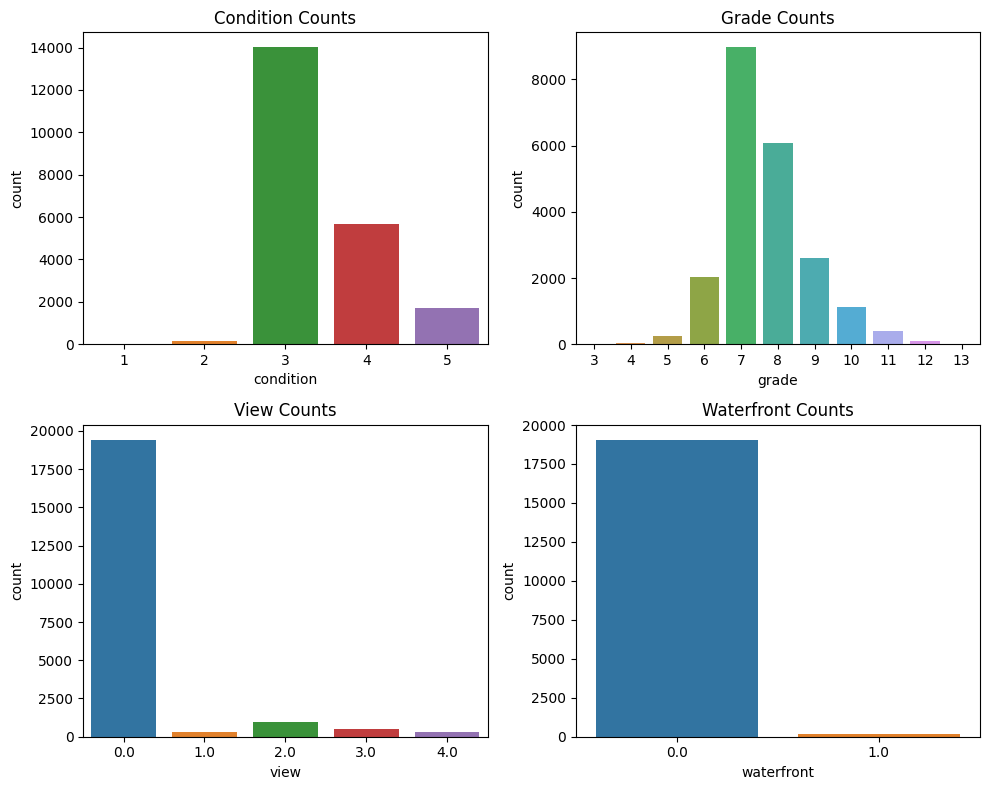

In [152]:
#First we start by inspecting the counts of some of these. I want to lay them all out together on a grid


columns_to_plot = ['condition', 'grade', 'view', 'waterfront']  # Add your desired columns here

# Create a grid of subplots, n rows and 1 column (adjust as needed)
n = len(columns_to_plot)  # Number of count plots you want
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Adjust figsize as needed. Since I'm doing 4 plots, i did 2x2

# Loop through each column to create count plots
for i, column in enumerate(columns_to_plot):
    row = i // 2  # Determine the row (integer division by 2)
    col = i % 2   # Determine the column (modulo 2)
    sns.countplot(x=column, data=df_king_county, ax=axes[row, col])  # Plot on the ith axis
    axes[row, col].set_title(f'{column.capitalize()} Counts')  # Add title to each plot

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


#The above code iterates over creating plots individually each way like seen below:
# sns.countplot(x='view', data=df_king_county)
# plt.title('View Counts');


# sns.countplot(x='condition', data=df_king_county)
# plt.title('Condition Counts');

These bar graphs give us a general idea of how many counts there are for each value of the categorical data. We can see that the majority of homes got a condition of "3.", the vast majority did not have a view and were not waterfront, and an expected grade for a home can be between 6 and 9.


# <span style="color:green"> __Research Questions and Hypotheses__ </span>


### <span style="color:lightgreen"> __Question 1__ </span>

* Do the houses in Seattle have worse condition on average?
#### <span style="color:white"> __Hypothesis 1__ </span>

* If a house is in Seattle, it is more likely to have a worse condition.


I want to create a "distance from city center" column based on giving a lat,long pair for "city center" and then computing the distance
using haversine.

In [153]:
center_latitude = 47.620564
center_longitude = -122.350616

city_center = (center_latitude, center_longitude)

#the columns which contain the lat and long information of houses are called lat and long. For haversine I need to make tuples

#This makes a new column containing the tuple by zipping the lat and long columns
df_king_county['lat_long_tuple'] = list(zip(df_king_county['lat'], df_king_county['long']))


#now I make a new column which has the distance from the city center calculated via haversine
df_king_county['distance_from_city_center'] = df_king_county['lat_long_tuple'].apply(lambda x: hs.haversine(x, city_center))

# Display the first few rows to check the new column
df_king_county[['lat_long_tuple', 'distance_from_city_center']].head()

,lat_long_tuple,distance_from_city_center
0,"(47.5112, -122.257)",14.043416
1,"(47.721, -122.319)",11.416139
2,"(47.7379, -122.233)",15.740509
3,"(47.5208, -122.393)",11.539974
4,"(47.6168, -122.045)",22.910440


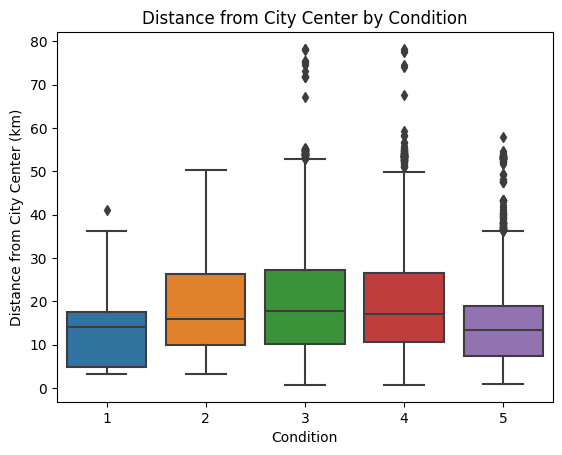

In [154]:
#Now I want to plot. The plan is to group by condition and then see the distribution of distances

sns.boxplot(x='condition', y='distance_from_city_center', data=df_king_county)

# Add labels and title
plt.title('Distance from City Center by Condition')
plt.xlabel('Condition')
plt.ylabel('Distance from City Center (km)')

plt.show()

Visually this indicates that there is not really a correlation between condition and distance. They all have roughly the same
min and median. Conditions 2, 3, and 4 have a slight skew towards further distance, but this is not significant. These findings are
supported by the insignificance of the correlation coefficient found below:

In [155]:
correlation = df_king_county['distance_from_city_center'].corr(df_king_county['condition'])

print(f"Correlation between distance from city center and condition: {correlation}")

Correlation between distance from city center and condition: -0.07236047967463276


There is a very very small negative correlation (-.07236...) which does not appear to be super meaningful. We can further see this lack of correlation by examining a regression line based on the median distance from the city center for each condition. Here it's important to use the median and not the mean because we can see that there are many outliers in the various condition box plots.

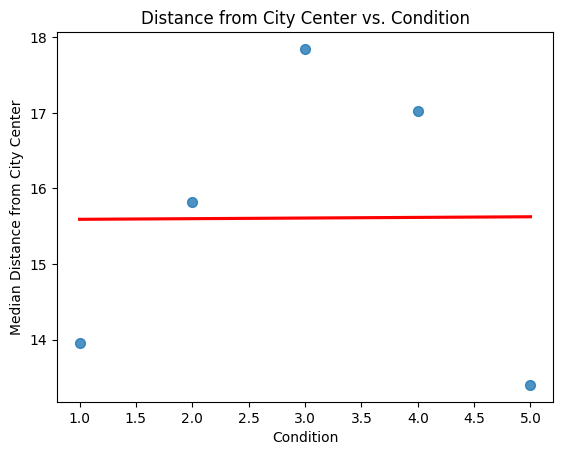

In [156]:
# Example: Group by condition and calculate the median
medians_kc = df_king_county.groupby('condition')['distance_from_city_center'].median().reset_index()

# Scatter plot with regression line
sns.regplot(data=medians_kc, x='condition', y='distance_from_city_center', ci=None, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Distance from City Center vs. Condition')
plt.xlabel('Condition')
plt.ylabel('Median Distance from City Center')
plt.show()

Clearly this regression line is almost horizontal, indicating that there is not really a correlation

### Hypothesis 1 Result: This hypothesis was proven incorrect, as there does not seem to be a correlation between the condition of a house and the distance from the city center.

One small additional question that this sparked is if this is also true for homes just in Seattle (not all of King County). The plot below demonstrates the scatter plot with a regression line comparing the median distance from the city center and condition for homes just in the Seattle data frame. This one gives more of an indication towards what the hypothesis assumed.

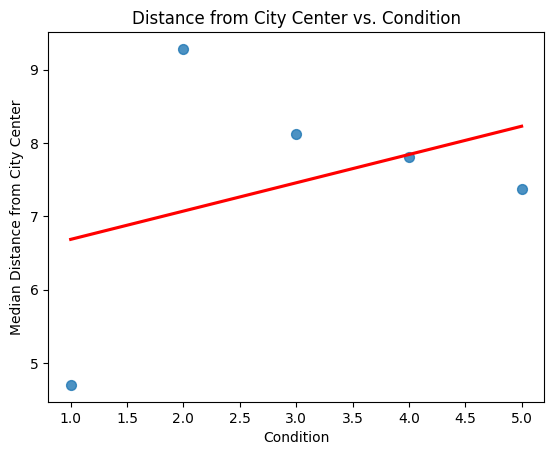

In [157]:
#What about just among the seattle houses?

df_seattle = df_king_county[df_king_county['is_in_seattle']] #since this is boolean it will only take those labeled true

#Group by condition and calculate the median distance from the city center
medians_s = df_seattle.groupby('condition')['distance_from_city_center'].median().reset_index()

# Scatter plot with regression line
sns.regplot(data=medians_s, x='condition', y='distance_from_city_center', ci=None, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Distance from City Center vs. Condition')
plt.xlabel('Condition')
plt.ylabel('Median Distance from City Center')
plt.show()

### <span style="color:lightgreen"> __Question 2__ </span>

* Do the houses in Seattle cost more?
#### <span style="color:white"> __Hypothesis 2__ </span>
* If a house is in Seattle, it is likely to cost more per square foot.



For this I think my approach will be to use the sub-data frame which only contains the columns with True in the is_in_seattle column. Then I
will run all of the same statistics on that and compare with the overall data frame for King County. It's also important that we are comparing price per square foot rather than price itself because this is a better measure of price comparison.


In [158]:
#print('Price per square foot King County:')
#df_king_county['price_per_sqft'].describe() #I did this for both king county and seattle only. The results are displayed below

<div style="display: grid; grid-template-columns: repeat(2, 1fr); gap: 10px;">
    <img src="images/ppsqft_seattle.png" alt="PPSQFT seattle" style="width: 100%; height: auto;">
    <img src="images/ppsqft_king_county.png" alt="PPSQFT king county" style="width: 100%; height: auto;">
</div>

I can see that the mean and median of houses in Seattle cost more than the overall values for all of King County. I want some visual aids to convey this information.

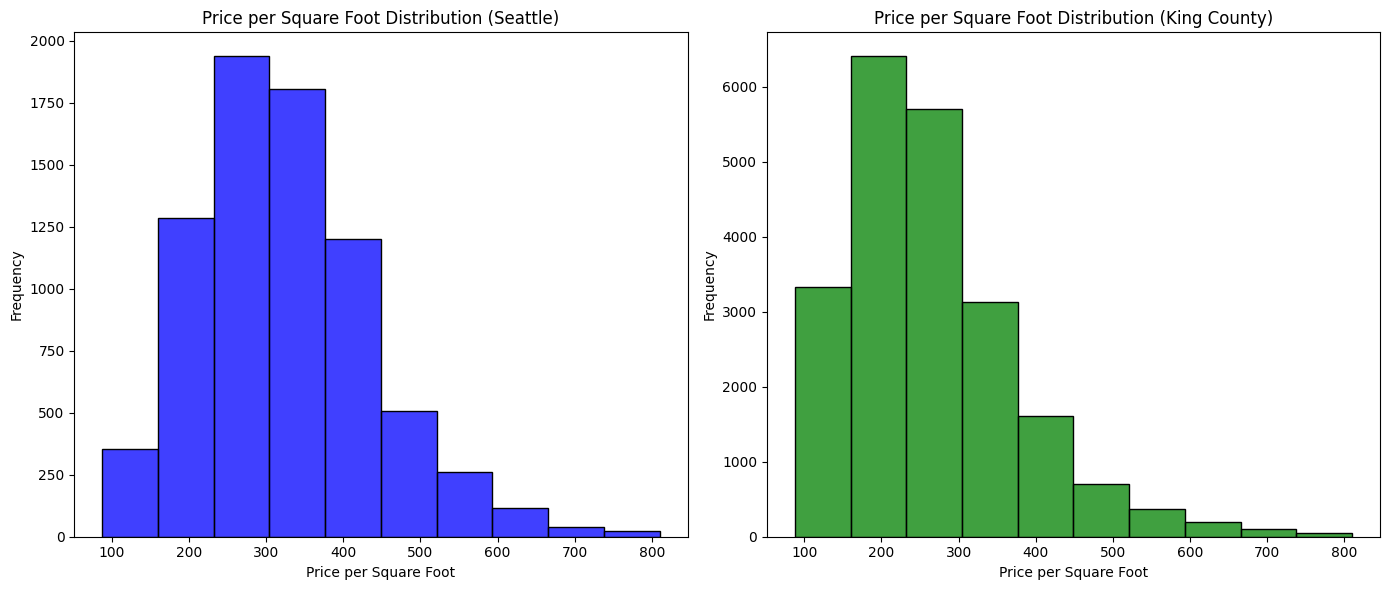

In [159]:
#I will also generate these as histograms to see if that is more insightful

# Create a figure with subplots (2 histograms side by side)
plt.figure(figsize=(14, 6))

# Plot the histogram for df_seattle
plt.subplot(1, 2, 1)  # (row, column, position)
sns.histplot(df_seattle['price_per_sqft'], color='blue', bins=10)
plt.title("Price per Square Foot Distribution (Seattle)")
plt.xlabel("Price per Square Foot")
plt.ylabel("Frequency")

# Plot the histogram for df_king_county
plt.subplot(1, 2, 2)  # (row, column, position)
sns.histplot(df_king_county['price_per_sqft'], color='green', bins=10)
plt.title("Price per Square Foot Distribution (King County)")
plt.xlabel("Price per Square Foot")
plt.ylabel("Frequency")

# Adjust the layout to make sure there's no overlap between plots
plt.tight_layout()

# Show the plot
plt.show()

From this we can visually verify that the distribution for King County is more heavily concentrated to the left than Seattle. This helps to visually confirm the hypothesis and the numbers given in the summary statistics. One thing to note is that the y-axes are different from one another. I think in this case because we are trying to determine relative frequency, this is actually more helpful.

### Hypothesis 2 Result: This hypothesis was proven correct, as the mean and median cost per square foot are greater for houses in Seattle as compared to all of King County. Further, we can see that the distribution in Seattle is shifted slightly more to the right.


### <span style="color:lightgreen"> __Question 3__ </span>

* Is having a view correlated with greater square footage?
#### <span style="color:white"> __Hypothesis 3__ </span>
* Higher view score is correlated with higher square footage

I'll start by taking a preliminary look at the box plots for each respective view score as they compare to square footage.

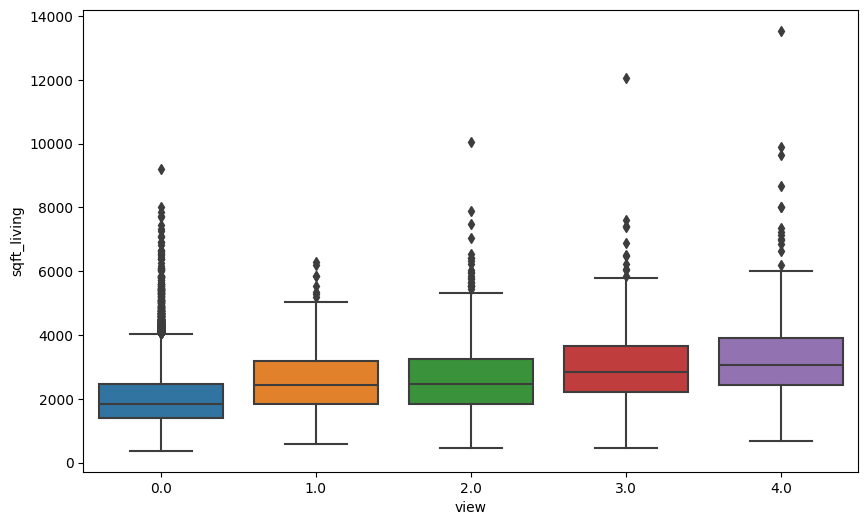

In [160]:
plt.figure(figsize=(10, 6))  # Set figure size a little larger than default for more detail
sns.boxplot(x='view', y='sqft_living', data=df_king_county);

I'm now going to see if these distributions are significantly different from one another (statistically) using what's called a Kruskal-Wallis H test. This will compare the medians and the distributions of the groups without assuming normality. It's important to use a test that takes medians into consideration rather than means because there are a high number of outliers for each "view" distribution. From a preliminary view of these, we can see a general trend upward in view score/square footage.

In [161]:
from scipy.stats import kruskal

# Perform Kruskal-Wallis test to compare the 'sqft_living' distribution across all 'view' categories
stat, p_value = kruskal(
    df_seattle[df_seattle['view'] == 0]['sqft_living'],  # for view = 0
    df_seattle[df_seattle['view'] == 1]['sqft_living'],  # for view = 1
    df_seattle[df_seattle['view'] == 2]['sqft_living'],  # for view = 2
    df_seattle[df_seattle['view'] == 3]['sqft_living'],  # for view = 3
    df_seattle[df_seattle['view'] == 4]['sqft_living']   # for view = 4
)

# Output the test statistic and p-value
print(f"Kruskal-Wallis test statistic: {stat}") #the test statistic determines the amount of variance between each group (view score)
print(f"P-value: {p_value}") #the p-value determines the likelihood of such a test statistic resulting

Kruskal-Wallis test statistic: 732.0092358682216
P-value: 4.082118512258247e-157


The resulting p-value is EXTREMELY small (4.08 x 10^(-157)) which indicates a strong correlation between a higher view score and a higher amount of square footage. The overwhelming evidence of this is surprising given how nominal the differences look in the comparison of box plots, however this relationship is consistent with the visual evidence. Perhaps a more helpful visual aid which conveys this is a scatter plot which takes the median of each view score and then assigns a regression line.

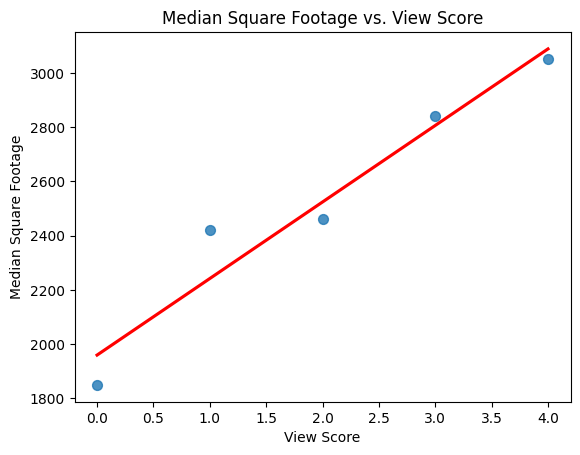

In [162]:
# Example: Group by view_score and calculate the median
medians = df_king_county.groupby('view')['sqft_living'].median().reset_index()

# Scatter plot with regression line
sns.regplot(data=medians, x='view', y='sqft_living', ci=None, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Median Square Footage vs. View Score')
plt.xlabel('View Score')
plt.ylabel('Median Square Footage')
plt.show()

This helps to visually confirm the strong relationship that's indicated by the test.

### Hypothesis 3 Result: This hypothesis was proven correct since there is a strong correlation between higher view score and higher square footage.

# <span style="color:green"> __Client Recommendations__ </span>

Nicole Johnson is a buyer who wants a lively, central neighborhood, middle price range, and to buy within a year. For recommendations, I am only going to use the subset of the data which is actually in Seattle. This is because determining a middle price range is going to depend not on all of King County, but the middle range that she can expect to pay for a home in the city. I have already made this data frame, called df_seattle. 


We have been using price per square foot to determine relative costs to each other, however middle price range really does refer to price itself, so that will be a metric that is used for recommendations. I will start with creating a data frame of mid-priced homes within Seattle which can be used to manage expectations for the client. This is determined by findng the median price of homes in Seattle and then making a data frame which only contains homes within 10% of that median price. This is done in the next cell and results in a total of 1312 homes which we can use as a basis for recommendations.

In [163]:
df_seattle['price'].describe()

#median price is 490,000, mean is 569,554 which is clearly skewed so I will again use the median.as_integer_ratio

#I'll again make a new data frame consisting only of those homes within 10% of the median price and try to compare
#those to see what my client can expect

median_price = 490000
lower_bound_price = median_price * 0.9
upper_bound_price = median_price * 1.10

df_seattle_mid_price = df_seattle[(df_seattle['price'] <= upper_bound_price) & (df_seattle['price'] >= lower_bound_price)]
#df_seattle_mid_price

#There are 1312 rows. Let's run some analysis on this data frame.

Below we can find important summary statistics from the .describe() function for various relevant features for mid-priced homes in Seattle. These will be used to guide the recommendations.

<div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 10px;">
    <img src="images/summary_mid_range_price.png" alt="Price" style="width: 100%; height: auto;">
    <img src="images/summary_mid_range_ppsqft.png" alt="Price per sqft" style="width: 100%; height: auto;">
    <img src="images/summary_mid_range_sqft_living.png" alt="Living space (sqft)" style="width: 100%; height: auto;">
    <img src="images/summary_mid_range_bedrooms.png" alt="Number of Bedrooms" style="width: 100%; height: auto;">
    <img src="images/summary_mid_range_bathrooms.png" alt="Number of Bathrooms" style="width: 100%; height: auto;">
    <img src="images/summary_mid_range_dist_from_cc.png" alt="Distance from City center" style="width: 100%; height: auto;">
    <img src="images/summary_mid_range_lot_sqft.png" alt="Lot square footage" style="width: 100%; height: auto;">
    <img src="images/summary_mid_range_floors.png" alt="Number of floors" style="width: 100%; height: auto;">
</div>

So what are we looking for? Well, she wants to be close to the city center. Based on her price range, she can expect that a house will be around 7.6 km away from the city center. Q1 for distance from city center is 5.7km so we may have less options in that range, but somewhere around that isn't unreasonable. Regarding her request for a lively neighborhood, this isn't always tied to the city center but this is still a good metric to have.


I would also like to see some time-related statistics for these since she has a full year to buy and so I could make a recommendation of when the best time to buy is.

## <span style="color:lightgreen"> __Recommendation 1: Buy a house during the second half of the year__ </span>

The justification for this recommendation is that Q3 has both a mean and median below the other quartiles when it comes to distance from the city center. Q4 is then the next lowest in distance from the city center and has the combined benefit that its price per square foot is less than all other quartiles (in both median and mean), so my client is more likely to get a better value if purchasing then. The work for these conclusions is shown below.

In [164]:
#I start by making data frames for each quarter which I can then run some analysis on

df_seattle_mid_price['date'].min() #the earliest day is May 2, 2014 
df_seattle_mid_price['date'].max() #and the latest is May 24, 2015


#Q1 must contain the dates between January 1, 2015 and March 31, 2015
df_seattle_mid_price_Q1 = df_seattle_mid_price[(df_seattle_mid_price['date'] <= '2015-03-31') & 
                                               (df_seattle_mid_price['date'] >= '2015-01-01')]


#Q2 overlaps for both years and must contain the dates between April 1 2015 and May 24, 2015 
# (since that is where the data ends). It must also contain the dates between May 2, 2014 and
#June 30, 2014. This is indicated with an "or" so that both ranges of values are included

df_seattle_mid_price_Q2 = df_seattle_mid_price[((df_seattle_mid_price['date'] >= '2015-04-01') & 
                                                (df_seattle_mid_price['date'] <= '2015-05-24')) | 
                                                ((df_seattle_mid_price['date'] >= '2014-05-02') & 
                                                 (df_seattle_mid_price['date'] <= '2014-06-30'))]


#Q3 must contain the dates between July 1, 2014 and September 30, 2014
df_seattle_mid_price_Q3 = df_seattle_mid_price[(df_seattle_mid_price['date'] >= '2014-07-01') & 
                                               (df_seattle_mid_price['date'] <= '2014-09-30')]


#Q4 must contain the dates between October 1, 2014 and December 31, 2014
df_seattle_mid_price_Q4 = df_seattle_mid_price[(df_seattle_mid_price['date'] >= '2014-10-01') & 
                                               (df_seattle_mid_price['date'] <= '2014-12-31')]


# Verify the counts for each quarter
print(f"Q1 count: {len(df_seattle_mid_price_Q1)}") #222
print(f"Q2 count: {len(df_seattle_mid_price_Q2)}") #449
print(f"Q3 count: {len(df_seattle_mid_price_Q3)}") #332
print(f"Q4 count: {len(df_seattle_mid_price_Q4)}") #309

# Verify the total count to make sure this split correctly
total_count = len(df_seattle_mid_price_Q1) + len(df_seattle_mid_price_Q2) + len(df_seattle_mid_price_Q3) + len(df_seattle_mid_price_Q4)
print(f"Total count across all quarters: {total_count}")


Q1 count: 222
Q2 count: 449
Q3 count: 332
Q4 count: 309
Total count across all quarters: 1312


I now have data frames for each quarter and can run some basic statistics on them to see when the best time to buy is. Based on my client's wants, I will look for two things - which quarter averages the best price per square foot AND which quarter has the most homes being sold close to the city center?

In [165]:
#I run these lines for each quarter Q1 through Q4 to get the summary statistics displayed below

# print('The distribution for Distance from city center for QX is:')
# df_seattle_mid_price_QX['distance_from_city_center'].describe()

<div style="display: grid; grid-template-columns: repeat(4, 1fr); gap: 10px;">
    <img src="images/ppsqft_q1.png" alt="PPSQFT Q1" style="width: 100%; height: auto;">
    <img src="images/ppsqft_q2.png" alt="PPSQFT Q2" style="width: 100%; height: auto;">
    <img src="images/ppsqft_q3.png" alt="PPSQFT Q3" style="width: 100%; height: auto;">
    <img src="images/ppsqft_q4.png" alt="PPSQFT Q4" style="width: 100%; height: auto;">
    <img src="images/dist_from_cc_q1.png" alt="Dist from city center Q1" style="width: 100%; height: auto;">
    <img src="images/dist_from_cc_q2.png" alt="Dist from city center Q2" style="width: 100%; height: auto;">
    <img src="images/dist_from_cc_q3.png" alt="Dist from city center Q3" style="width: 100%; height: auto;">
    <img src="images/dist_from_cc_q4.png" alt="Dist from city center Q4" style="width: 100%; height: auto;">
</div>

I would like to make a visual aid to help convey this recommendation

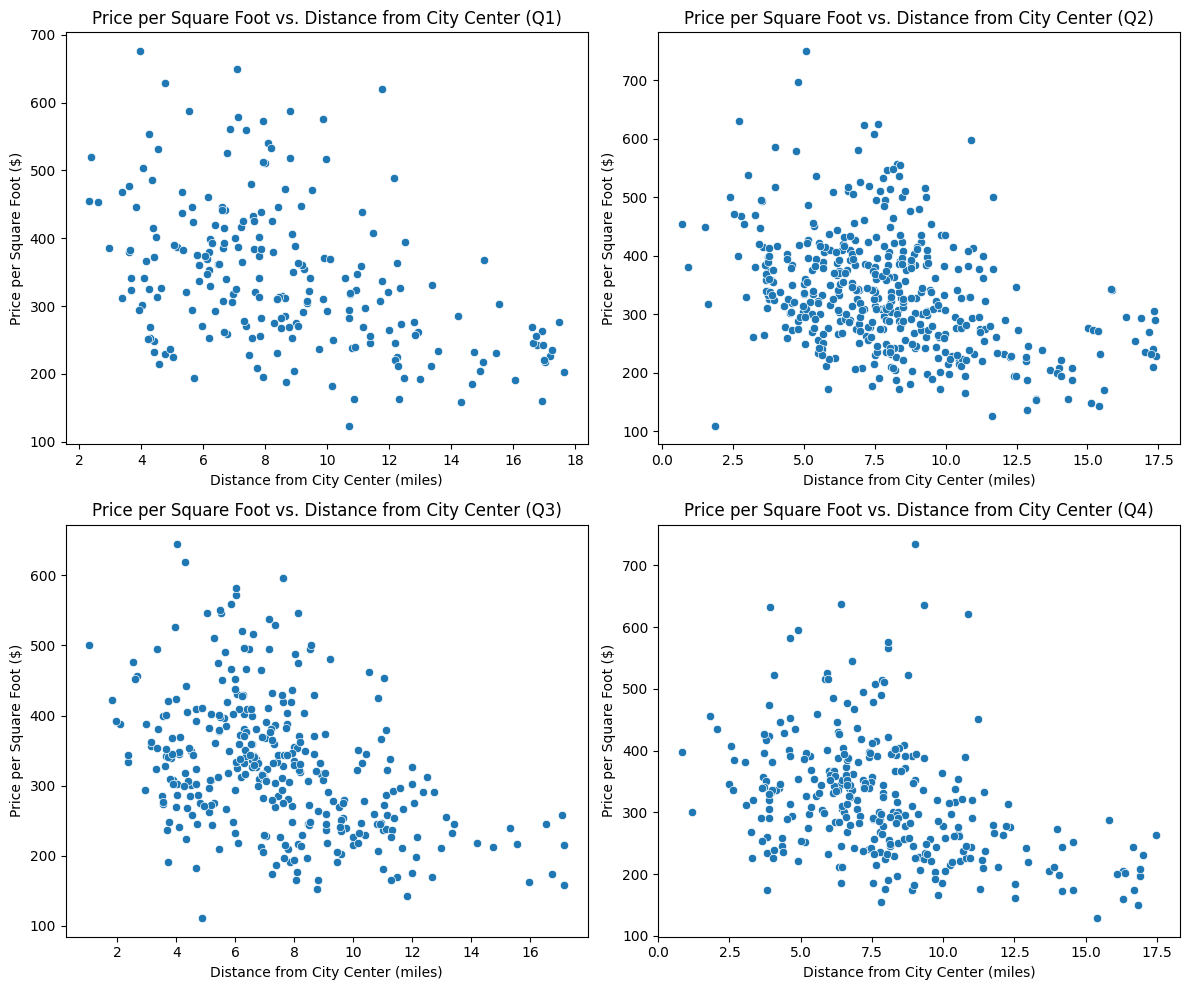

In [166]:
#I will make a list of the quarters and iterate the creation of the scatter plot. Then I will have them
#display in a 2x2 grid

quarters = ['Q1', 'Q2', 'Q3', 'Q4']

# Add a 'quarter' column to each DataFrame to identify the quarter using .loc 
# (without using .loc i got a warning)
df_seattle_mid_price_Q1.loc[:, 'quarter'] = 'Q1'
df_seattle_mid_price_Q2.loc[:, 'quarter'] = 'Q2'
df_seattle_mid_price_Q3.loc[:, 'quarter'] = 'Q3'
df_seattle_mid_price_Q4.loc[:, 'quarter'] = 'Q4'

# Concatenate all DataFrames into one
df_combined = pd.concat([df_seattle_mid_price_Q1, 
                         df_seattle_mid_price_Q2, 
                         df_seattle_mid_price_Q3, 
                         df_seattle_mid_price_Q4])


# Set up a plot with subplots for each quarter
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns for 4 quarters
axes = axes.flatten()  # Flatten the 2x2 array of axes for easier indexing

# Loop through each quarter and plot a separate scatter plot
for i, quarter in enumerate(quarters):
    # Filter data for the current quarter
    quarter_data = df_combined[df_combined['quarter'] == quarter]
    
    # Scatter plot for each quarter
    sns.scatterplot(x='distance_from_city_center', y='price_per_sqft', data=quarter_data, ax=axes[i])
    axes[i].set_title(f'Price per Square Foot vs. Distance from City Center ({quarter})')
    axes[i].set_xlabel('Distance from City Center (miles)')
    axes[i].set_ylabel('Price per Square Foot ($)')

# Adjust layout for better spacing between plots
plt.tight_layout()
plt.show()

## <span style="color:lightgreen"> __Recommendation 2: Don't buy a house with less than 3 bedrooms.__ </span>

For this I use the summary statistics of the bedroom count for houses in this price range. Both the median and Q3 are 3 bedrooms, indicating a high concentration around this value. It therefore seems that within this price range, buying a houses with less than 3 bedrooms is suboptimal. 


The first justification for this recommendation is that the percentage of homes in this price range with less than 3 bedrooms is quite low. This means that she should expect to be able to buy a home with at least 3 bedrooms.


In [167]:
df_seattle_mid_price['bedrooms'].count()

#there are 373 homes with 2 bedrooms and 8 homes with 1 bedroom for a total of 381 homes less than 3 bedrooms.
#there are 1312 values in this data frame

percentage = round(373 / 1312 * 100)
print(f'The percentage of mid-priced homes in Seattle with less than 3 bedrooms is {percentage}%')

The percentage of mid-priced homes in Seattle with less than 3 bedrooms is 28%


The second justification is visual, looking at the distribution of the number of bedrooms within this price range.

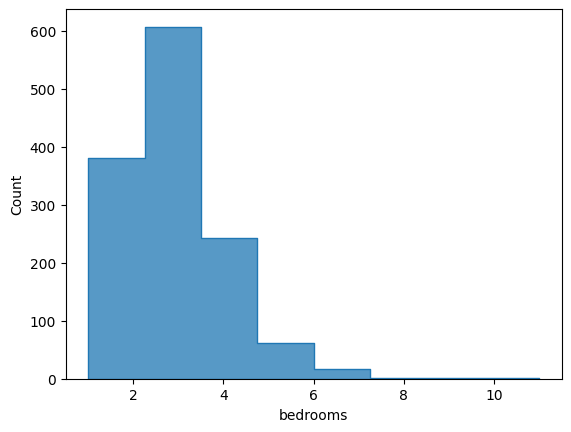

In [168]:
#Second justification (visual)
sns.histplot(data=df_seattle_mid_price, x='bedrooms', 
             bins=8, kde=False, element='step');

## <span style="color:lightgreen"> __Recommendation 3: Look for a home in the $513,000 - $539,000 price range.__ </span>

Justification: Spending in this range is more likely to end up with a better location. To test this, I am going to divide homes into two groups - homes below the 75th percentile and homes above. Then I am going to compare the median distance from the city center among both groups and use a statistical test to determine if the difference in the distributions is statistically significant. Because my client cares a lot about being in a lively area and all the homes we are selecting from are still within the mid-range price level, it is best to recommend searching within the price range that will meet her needs the most.

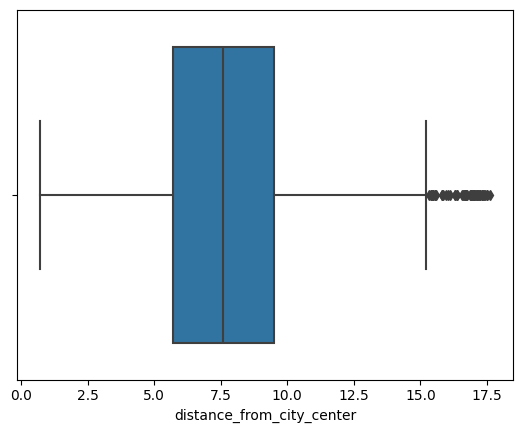

In [169]:
sns.boxplot(x=df_seattle_mid_price['distance_from_city_center']); #We see that there are many outliers so I am going to use the median

Now I am going to run what's known as a Mann-Whitney U test. This test compares the distributions of two independent groups (here groups within the bottom 75% of prices and homes within the upper 25%). The Null Hypothesis for this type of test states that there is no relationship between price and distance from city center. We see that because our p-value is below the threshold of 0.05, we must reject the null hypothesis. This means that there IS a significant correlation. Running this type of test is super useful because simply comparing the medians by eye seems like it is not that significant, however this test takes more into account about the entire distribution.

In [170]:
import scipy.stats as stats

# Step 1: Calculate the 75th percentile (Q3) of home prices to define the upper quartile
q3_price = df_seattle_mid_price['price'].quantile(0.75) #I also verified that this matched with the
                                                        # summary statistics found above

# Step 2: Create two groups based on home prices
# Upper quartile (Q3 and above)
upper_quartile = df_seattle_mid_price[df_seattle_mid_price['price'] >= q3_price]

# Lower 75% (less than Q3)
lower_75 = df_seattle_mid_price[df_seattle_mid_price['price'] < q3_price]

# Step 3: Calculate the median distance from the city center for each group
median_distance_upper = upper_quartile['distance_from_city_center'].median()
median_distance_lower = lower_75['distance_from_city_center'].median()

# Print the medians
print(f"Median distance for upper quartile: {median_distance_upper}")
print(f"Median distance for lower 75%: {median_distance_lower}")

# Step 4: Perform a Mann-Whitney U test to check for significant difference
stat, p_value = stats.mannwhitneyu(upper_quartile['distance_from_city_center'], 
                                   lower_75['distance_from_city_center'])

# Print the test result
print(f"Test statistic: {stat}")   #this measures the degree of difference between the two distributions.
print(f"P-value: {p_value}")       #and this reports how likely it is that this degree of difference was detected

# Conclusion based on p-value (e.g., if p-value < 0.05, we reject the null hypothesis)
if p_value < 0.05:
    print("The difference in median distances is statistically significant.")
else:
    print("The difference in median distances is not statistically significant.")

Median distance for upper quartile: 7.225214086822179
Median distance for lower 75%: 7.782364208956551
Test statistic: 146761.0
P-value: 0.010343144728629948
The difference in median distances is statistically significant.
